In [737]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator

In [738]:
Ti = np.array([1/12, 3/12, 6/12])
ri = np.array([0.03703, 0.0393, 0.04146])       ## 1M, 3M, 6M SOFR OIS average from FRED NY 

In [739]:
DF_i = np.exp( - ri * Ti)
DF_i

array([0.99691892, 0.99022311, 0.97948339])

In [740]:
# Compute last forward rate 
T_last = Ti[-1]
DF_last = DF_i[-1]

f_last = -np.log(DF_last) / T_last
f_last

0.04145999999999995

In [741]:
# Building Interpolator

logDF_interp = PchipInterpolator( Ti, np.log(DF_i))

In [742]:
def DF_r(T):
    T = np.asarray(T, dtype = float)
    DF = np.empty_like(T)
    if T <= T_last:
        DF = np.exp(logDF_interp(T))
    else:
        DF = DF_last * np.exp( - f_last * ( T - T_last))
    return DF


In [743]:
T = np.array([1.25, 1.75, 2.25, 2.75])

DF_Ti = [ DF_r(t) for t in zip(T)]

DF_Ti

[array([0.94949501]),
 array([0.93001459]),
 array([0.91093385]),
 array([0.89224457])]

In [744]:
# Sanity check 

ts = np.linspace(0.01, 5, 300)
DF_ts = [DF_r(t) for t in ts]


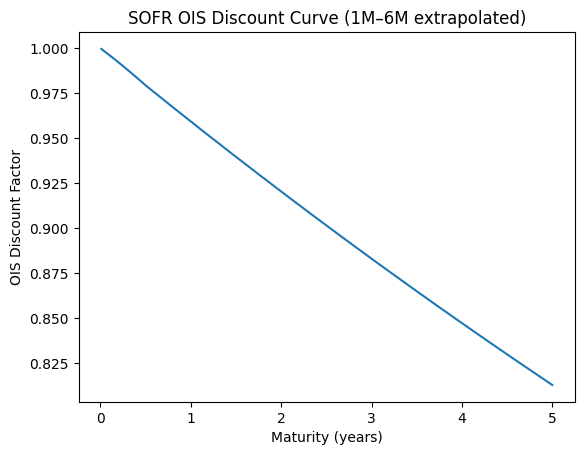

In [745]:
import matplotlib.pyplot as plt

plt.plot(ts, DF_ts)
plt.xlabel("Maturity (years)")
plt.ylabel("OIS Discount Factor")
plt.title("SOFR OIS Discount Curve (1M–6M extrapolated)")
plt.show()

In [746]:
T = np.array([1, 1.5, 2, 2.5, 3])
DF_Ti = []
for t in T:
    DF_ti = DF_r(t)
    DF_Ti.append(DF_ti)
DF_Ti = np.asarray(DF_Ti)
DF_Ti

array([0.95938771, 0.93970433, 0.92042478, 0.90154078, 0.88304422])

In [747]:
S0 = 248.35
K_grid = np.array([240, 250, 260, 270, 300])
C_grid = np.array([35.53, 30.03, 24.75, 20.27, 16.47])
P_grid = np.array([19.73, 23.95, 28.85, 34.45, 41.25])
T = np.array([1, 1.5, 2, 2.5, 3])

STEP 1 — Build market-implied forwards

In [749]:
F_mkt = ( C_grid - P_grid ) + K_grid
F_mkt

array([255.8 , 256.08, 255.9 , 255.82, 275.22])

STEP 2 — PV of cumulative implied dividends

In [751]:
pv_div = S0 - F_mkt * DF_Ti
pv_div

array([ 2.93862376,  7.7105162 , 12.81329924, 17.71783728,  5.31856968])

In [752]:
# The negative last value is a market inconsistency / strike mismatch, not a math error. 
# This is very common and exactly why SMOOTHING is needed later.

STEP 3 — Cumulative cash implied dividends

In [754]:
D_cum = pv_div / DF_Ti
D_cum

array([ 3.06302002,  8.20525774, 13.9210716 , 19.65284061,  6.0229936 ])

STEP 4 — Future (interval) implied dividends

In [756]:
dividend = []
d_time = []

for i in range(1, len(T)):
    T1, T2 = T[i-1], T[i]
    t_mid = 0.5 * (T1 + T2)

    D_i = (pv_div[i] - pv_div[i-1]) / DF_Ti[i]

    dividend.append(D_i)
    d_time.append(t_mid)

dividend = np.array(dividend)
d_time = np.array(d_time)

dividend


array([  5.07807861,   5.54394359,   5.44017324, -14.04150247])

In [757]:
# Same reason as above 

STEP 5 — Dividend Discount Factor curve

In [759]:
DF_d = S0 * DF_Ti / F_mkt
DF_d

array([0.9314462 , 0.91133852, 0.89326883, 0.87521559, 0.79683174])

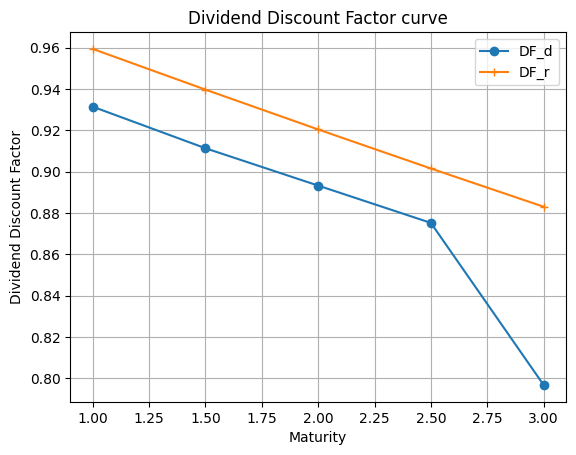

In [760]:
plt.plot(T, DF_d, label = 'DF_d', marker = 'o')
plt.plot(T, DF_Ti, label = 'DF_r', marker = '+')
plt.xlabel('Maturity')
plt.ylabel('Dividend Discount Factor')
plt.title('Dividend Discount Factor curve')
plt.grid(0.25)
plt.legend()

STEP 6 — Dividend forward rates (optional but powerful)     ====> this is used for continuos dividend based pricing f(d) = q(d)

In [762]:
fwd_div = (np.log(DF_d[:-1]) - np.log(DF_d[1:])) / np.diff(T)
fwd_div


array([0.04364801, 0.0400537 , 0.04083466, 0.18765341])

In [763]:
# For Discrete Dividend
S_adj = S0 - np.sum(dividend * DF_Ti[1:])
S_adj

245.97005407606719

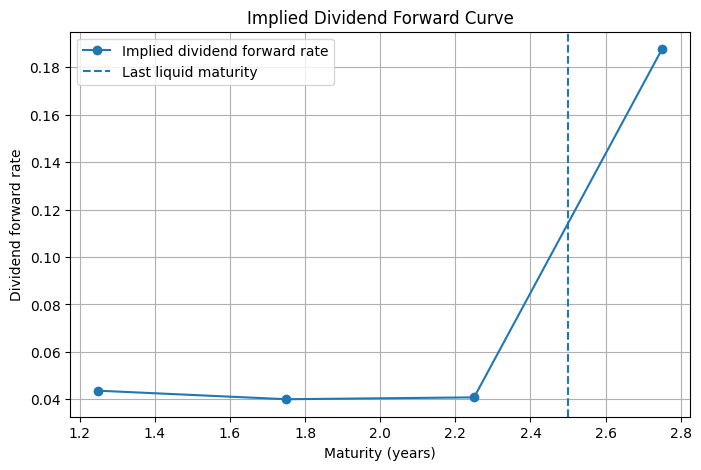

In [764]:
import matplotlib.pyplot as plt
import numpy as np

# mid-point times for plotting
T_mid = 0.5 * (T[:-1] + T[1:])

plt.figure(figsize=(8,5))
plt.plot(T_mid, fwd_div, marker='o', label='Implied dividend forward rate')

# mark last liquid maturity
plt.axvline(2.5, linestyle='--', label='Last liquid maturity')

plt.xlabel('Maturity (years)')
plt.ylabel('Dividend forward rate')
plt.title('Implied Dividend Forward Curve')
plt.legend()
plt.grid(True)
plt.show()
